<a href="https://colab.research.google.com/github/graveo-wicaksana/DA_restaurantSales/blob/main/DA_restaurantSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
In your city, there are a new restaurant that has opened recently. This restaurant has sold various foods and drinks to customers for certain time. The owner wants to look at the sales data. As a new officer, you has been pointed to analyze the data to give insights and propose recommendations.

# Key Performance Indicators
1.   Finding most ordered item for each categories
2.   Listing the prefered items for certain payment method
3.   Explain the trend sales during a year to find high sales on certain months
4.   Recommend marketing strategic to increase sales and/or engage more customers



# Preparation Datasets
The dataset is obtained from kaggle by Ahmed Mohamed with title "Restaurant Sales-Dirty Data for Cleaning Training". I have downloaded the file and stored in google drive to prevent error execution in the future in case the author move the path of the file. Hopefully, people will download the file from kaggle's author in this [link](https://www.kaggle.com/datasets/ahmedmohamed2003/restaurant-sales-dirty-data-for-cleaning-training).

The dataset will be processed using Python in this Jupyter Notebook.

In [1]:
#Load Library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load file and show top 5 records.
url = 'http://drive.google.com/file/d/1H1ya5-Dv4Pq-ony2SbsFMKvzZ3Yp_Df0/view?usp=sharing'
url = 'http://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head()

,Order ID,Customer ID,Category,Item,Price,Quantity,Order Total,Order Date,Payment Method
0,ORD_705844,CUST_092,Side Dishes,Side Salad,3.0,1.0,3.0,2023-12-21,Credit Card
1,ORD_338528,CUST_021,Side Dishes,Mashed Potatoes,4.0,3.0,12.0,2023-05-19,Digital Wallet
2,ORD_443849,CUST_029,Main Dishes,Grilled Chicken,15.0,4.0,60.0,2023-09-27,Credit Card
3,ORD_630508,CUST_075,Drinks,NaN,NaN,2.0,5.0,2022-08-09,Credit Card
4,ORD_648269,CUST_031,Main Dishes,Pasta Alfredo,12.0,4.0,48.0,2022-05-15,Cash


In [3]:
#Show info of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17534 entries, 0 to 17533
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order ID        17534 non-null  object 
 1   Customer ID     17534 non-null  object 
 2   Category        17534 non-null  object 
 3   Item            15776 non-null  object 
 4   Price           16658 non-null  float64
 5   Quantity        17104 non-null  float64
 6   Order Total     17104 non-null  float64
 7   Order Date      17534 non-null  object 
 8   Payment Method  16452 non-null  object 
dtypes: float64(3), object(6)
memory usage: 1.2+ MB


In [4]:
#Show descriptif statistic of numeric data type using describe
df.describe()

,Price,Quantity,Order Total
count,16658.000000,17104.000000,17104.000000
mean,6.586325,3.014149,19.914494
std,4.834652,1.414598,18.732549
min,1.000000,1.000000,1.000000
25%,3.000000,2.000000,7.500000
50%,5.000000,3.000000,15.000000
75%,7.000000,4.000000,25.000000
max,20.000000,5.000000,100.000000


In [5]:
#Show descriptif statistic of object data type using describe
df.describe(include="object")

,Order ID,Customer ID,Category,Item,Order Date,Payment Method
count,17534,17534,17534,15776,17534,16452
unique,17534,100,5,26,730,3
top,ORD_680707,CUST_066,Main Dishes,Pasta Alfredo,2023-11-25,Credit Card
freq,1,207,3551,998,42,5504


# Preprocessing Datasets

Do cleaning process to get clean dataset by checking and handling:
1. Duplicated records
2. Null records
3. Inconsistent records (i.e. format, and categories), Typo records, and Invalid records


## Handling Duplicated Records

In [6]:
#check duplicated records
df.duplicated().sum()

np.int64(0)

## Handling Null Value

In [7]:
#check null records.
print ("Total null records of each columns")
print (df.isna().sum())
print ("\n")

#check null percentage
print ("Null percentage of each columns")
na_columns = [i for i in df.columns if df[i].isna().mean() > 0]
df_na_columns = df[na_columns].isna().mean().round(2)
print (df_na_columns)


Total null records of each columns
Order ID             0
Customer ID          0
Category             0
Item              1758
Price              876
Quantity           430
Order Total        430
Order Date           0
Payment Method    1082
dtype: int64


Null percentage of each columns
Item              0.10
Price             0.05
Quantity          0.02
Order Total       0.02
Payment Method    0.06
dtype: float64


Percentage of NaN values in 'Item' columns is about 10%. The NaN values will be imputed to prevent significant loss.
Although for other columns are less than 10%, it will be done by imputed too to prevent data loss.

### Numeric Datatype

This section will handle null values for Price, Quantity and Order Total. Since the relations among them is Price multiply by Quantity resulting Order total, it will be handled first.

In [8]:
#keep the origin
df2 = pd.DataFrame(df)

#Handling price column
print ("Handling NaN value in Price column")
print ("Before: ", df2['Price'].isna().sum())
df2['Price'] = df2['Price'].fillna(df2['Order Total']/df2['Quantity']) #target fill na 876
print ("After: ", df2['Price'].isna().sum(), "\n") #remaining na is 430.

#Handling Quantity Column
print ("Handling NaN value in Quantity column")
print ("Before: ", df2['Quantity'].isna().sum())
df2['Quantity'] = df2['Quantity'].fillna(df2['Order Total']/df2['Price']) #target fill na 430
print ("After: ", df2['Quantity'].isna().sum(), "\n") #still 430.

#Handling order total Column
print ("Handling NaN value in Order Total column")
print ("Before: ", df2['Order Total'].isna().sum())
df2['Order Total'] = df2['Order Total'].fillna(df2['Price']*df2['Quantity']) #target fill na 430
print ("After: ", df2['Order Total'].isna().sum()) #still 430.



Handling NaN value in Price column
Before:  876
After:  430 

Handling NaN value in Quantity column
Before:  430
After:  430 

Handling NaN value in Order Total column
Before:  430
After:  430


There are 430 rows of NaN value for these three columns. It concludes that they are in the same rows due to the fact that three columns are related to each other. So these rows will be dropped.

In [9]:
df2.dropna(subset = ['Price', 'Quantity', 'Order Total'], inplace=True)

### Item column

In [10]:
#To handling item values, use menu map from source. The menu map will be written in a new dataset
df_menumap = pd.DataFrame({
    'Category': ['Starters', 'Starters', 'Starters', 'Starters', 'Starters', 'Starters',
                'Main Dishes', 'Main Dishes', 'Main Dishes', 'Main Dishes', 'Main Dishes',
                'Desserts', 'Desserts', 'Desserts', 'Desserts', 'Desserts',
                'Drinks', 'Drinks', 'Drinks', 'Drinks', 'Drinks',
                'Side Dishes', 'Side Dishes', 'Side Dishes', 'Side Dishes', 'Side Dishes'],
    'Item' : ['Chicken Melt', 'French Fries', 'Cheese Fries', 'Sweet Potato Fries', 'Beef Chili', 'Nachos Grande',
             'Grilled Chicken', 'Steak', 'Pasta Alfredo', 'Salmon', 'Vegetarian Platter',
             'Chocolate Cake', 'Ice Cream', 'Fruit Salad', 'Cheesecake', 'Brownie',
             'Coca Cola', 'Orange Juice', 'Lemonade', 'Iced Tea', 'Water',
             'Mashed Potatoes', 'Grilled Vegetables', 'Side Salad', 'Garlic Bread', 'Onion Rings'],
    'Price' : [8.0, 4.0, 5.0, 5.0, 7.0, 10.0,
               15.0, 20.0, 12.0, 18.0, 14.0,
               6.0, 5.0, 4.0, 7.0, 6.0,
               2.5, 3.0, 3.0, 2.5, 1.0,
               4.0, 5.0, 3.0, 4.0, 5.0]
})

#preview menumap
df_menumap.sort_values(by=['Category', 'Price'], ascending=[True, True])

,Category,Item,Price
13,Desserts,Fruit Salad,4.0
12,Desserts,Ice Cream,5.0
11,Desserts,Chocolate Cake,6.0
15,Desserts,Brownie,6.0
14,Desserts,Cheesecake,7.0
20,Drinks,Water,1.0
16,Drinks,Coca Cola,2.5
19,Drinks,Iced Tea,2.5
17,Drinks,Orange Juice,3.0
18,Drinks,Lemonade,3.0


In [11]:
#keep the rows without NaN Values in item column.
no_nan_item = df2['Item'].notna()
df2_no_nan_item = df2[no_nan_item].copy()

#Examine existing df with Na Values for each price
sum_nan_grouped = df2.groupby(['Category', 'Price'], dropna=False)['Item'].apply(lambda x: x.isna().sum())
print ("Item with NaN value grouped by Category & Price")
print (sum_nan_grouped)

Item with NaN value grouped by Category & Price
Category     Price
Desserts     4.0       43
             5.0       83
             6.0      103
             7.0       37
Drinks       1.0       99
             2.5       95
             3.0       94
Main Dishes  12.0      84
             14.0      36
             15.0      61
             18.0      37
             20.0      45
Side Dishes  3.0       88
             4.0       82
             5.0      100
Starters     4.0       70
             5.0       83
             7.0       33
             8.0       39
             10.0      16
Name: Item, dtype: int64


In [12]:
#Examine menu with duplicate price for different items
duplicate_menu_cost = df_menumap.duplicated(subset=['Category', 'Price'], keep=False)
df_menumap[duplicate_menu_cost].sort_values(by=['Category', 'Price'], ascending=[True,False])






,Category,Item,Price
11,Desserts,Chocolate Cake,6.0
15,Desserts,Brownie,6.0
17,Drinks,Orange Juice,3.0
18,Drinks,Lemonade,3.0
16,Drinks,Coca Cola,2.5
19,Drinks,Iced Tea,2.5
22,Side Dishes,Grilled Vegetables,5.0
25,Side Dishes,Onion Rings,5.0
21,Side Dishes,Mashed Potatoes,4.0
24,Side Dishes,Garlic Bread,4.0


Knowing price with duplicate items, it must be aware to handling NaN value with category and price like above. So, to handling NaN value in item columns, do separation handling process between unique price and same price.

#### Unique Price

In [13]:
#Variable Filter NaN Item
na_item = df2['Item'].isna()

#Handling Dessert Category for unique amount and non NaN
#Variable Filter Desserts
na_desserts = df2['Category'] == 'Desserts'
#Variable Filter Amount
na_desserts_unique_price = df2['Price'] != 6.0
#Execution
df2_na_desserts_unique_price = df2[na_desserts & na_desserts_unique_price & na_item].copy()
merged_df2_na_desserts_unique_price = pd.merge(df2_na_desserts_unique_price, df_menumap, on=['Category', 'Price'], how='left')
merged_df2_na_desserts_unique_price.dropna(subset=['Price'], inplace=True)
merged_df2_na_desserts_unique_price['Item_x'] = merged_df2_na_desserts_unique_price['Item_x'].fillna(merged_df2_na_desserts_unique_price['Item_y'])
merged_df2_na_desserts_unique_price = merged_df2_na_desserts_unique_price.rename(columns={'Item_x': 'Item'})
merged_df2_na_desserts_unique_price.drop(columns=['Item_y'], inplace=True)

#Handling Drinks Category for unique amount and non NaN
#Variable Filter Drinks
na_drinks = df2['Category'] == 'Drinks'
#Variable Filter Amount
na_drinks_unique_price = df2['Price'] == 1.0
#Execution
df2_na_drinks_unique_price = df2[na_drinks & na_drinks_unique_price & na_item].copy()
merged_df2_na_drinks_unique_price = pd.merge(df2_na_drinks_unique_price, df_menumap, on=['Category', 'Price'], how='left')
merged_df2_na_drinks_unique_price.dropna(subset=['Price'], inplace=True)
merged_df2_na_drinks_unique_price['Item_x'] = merged_df2_na_drinks_unique_price['Item_x'].fillna(merged_df2_na_drinks_unique_price['Item_y'])
merged_df2_na_drinks_unique_price = merged_df2_na_drinks_unique_price.rename(columns={'Item_x': 'Item'})
merged_df2_na_drinks_unique_price.drop(columns=['Item_y'], inplace=True)

#Handling Main Dishes Category for non NaN. All amounts are unique
#Variable Filter Main Dishes
na_main_dishes = df2['Category'] == 'Main Dishes'
#Execution
df2_na_main_dishes_unique_price = df2[na_main_dishes & na_item].copy()
merged_df2_na_main_dishes_unique_price = pd.merge(df2_na_main_dishes_unique_price, df_menumap, on=['Category', 'Price'], how='left')
merged_df2_na_main_dishes_unique_price.dropna(subset=['Price'], inplace=True)
merged_df2_na_main_dishes_unique_price['Item_x'] = merged_df2_na_main_dishes_unique_price['Item_x'].fillna(merged_df2_na_main_dishes_unique_price['Item_y'])
merged_df2_na_main_dishes_unique_price = merged_df2_na_main_dishes_unique_price.rename(columns={'Item_x': 'Item'})
merged_df2_na_main_dishes_unique_price.drop(columns=['Item_y'], inplace=True)

#Handling Side Dishes Category for unique amount and non NaN
#Variable Filter Side Dishes
na_side_dishes = df2['Category'] == 'Side Dishes'
#Variable Filter Amount
na_side_dishes_unique_price = df2['Price'] == 3.0
#Execution
df2_na_side_dishes_unique_price = df2[na_side_dishes & na_side_dishes_unique_price & na_item].copy()
merged_df2_na_side_dishes_unique_price = pd.merge(df2_na_side_dishes_unique_price, df_menumap, on=['Category', 'Price'], how='left')
merged_df2_na_side_dishes_unique_price.dropna(subset=['Price'], inplace=True)
merged_df2_na_side_dishes_unique_price['Item_x'] = merged_df2_na_side_dishes_unique_price['Item_x'].fillna(merged_df2_na_side_dishes_unique_price['Item_y'])
merged_df2_na_side_dishes_unique_price = merged_df2_na_side_dishes_unique_price.rename(columns={'Item_x': 'Item'})
merged_df2_na_side_dishes_unique_price.drop(columns=['Item_y'], inplace=True)

#Handling Starters Category for unique amount and non NaN
#Variable Filter Starters
na_starters = df2['Category'] == 'Starters'
#Variable Filter Amount
na_starters_unique_price = df2['Price'] != 5.0
#Execution
df2_na_starters_unique_price = df2[na_starters & na_starters_unique_price & na_item].copy()
merged_df2_na_starters_unique_price = pd.merge(df2_na_starters_unique_price, df_menumap, on=['Category', 'Price'], how='left')
merged_df2_na_starters_unique_price.dropna(subset=['Price'], inplace=True)
merged_df2_na_starters_unique_price['Item_x'] = merged_df2_na_starters_unique_price['Item_x'].fillna(merged_df2_na_starters_unique_price['Item_y'])
merged_df2_na_starters_unique_price = merged_df2_na_starters_unique_price.rename(columns={'Item_x': 'Item'})
merged_df2_na_starters_unique_price.drop(columns=['Item_y'], inplace=True)


#Combine all
df2_na_unique_price_concat = [merged_df2_na_desserts_unique_price,
                              merged_df2_na_drinks_unique_price,
                              merged_df2_na_main_dishes_unique_price,
                              merged_df2_na_side_dishes_unique_price,
                              merged_df2_na_starters_unique_price]
df2_na_concat_unique_price = pd.concat(df2_na_unique_price_concat)
df2_na_concat_unique_price

,Order ID,Customer ID,Category,Item,Price,Quantity,Order Total,Order Date,Payment Method
0,ORD_337802,CUST_034,Desserts,Fruit Salad,4.0,5.0,20.0,2022-11-13,Credit Card
1,ORD_499199,CUST_079,Desserts,Ice Cream,5.0,5.0,25.0,2022-02-12,Digital Wallet
2,ORD_308575,CUST_075,Desserts,Ice Cream,5.0,2.0,10.0,2023-01-06,Cash
3,ORD_238689,CUST_004,Desserts,Ice Cream,5.0,1.0,5.0,2023-06-28,Digital Wallet
4,ORD_337679,CUST_012,Desserts,Ice Cream,5.0,5.0,25.0,2022-11-28,Digital Wallet
...,...,...,...,...,...,...,...,...,...
153,ORD_678286,CUST_032,Starters,Chicken Melt,8.0,4.0,32.0,2023-03-20,NaN
154,ORD_644105,CUST_072,Starters,Beef Chili,7.0,1.0,7.0,2022-09-18,Digital Wallet
155,ORD_796904,CUST_070,Starters,Chicken Melt,8.0,4.0,32.0,2022-10-28,Credit Card
156,ORD_498941,CUST_007,Starters,French Fries,4.0,2.0,8.0,2023-06-25,Credit Card


#### Duplicate Price

In [14]:
#check mode value for duplicate price of NaN items for each category
#desserts
no_nan_desserts_p6 = (df2['Category'] == 'Desserts') & (df2['Price'] == 6.0)
desserts_p6 = df2[no_nan_desserts_p6][['Category', 'Item']]['Item'].mode()[0]

# drinks
no_nan_drinks_p3 = (df2['Category'] == 'Drinks') & (df2['Price'] == 3.0)
drinks_p3 = df2[no_nan_drinks_p3][['Category', 'Item']]['Item'].mode()[0]

no_nan_drinks_p2_5 = (df2['Category'] == 'Drinks') & (df2['Price'] == 2.5)
drinks_p2_5 = df2[no_nan_drinks_p2_5][['Category', 'Item']]['Item'].mode()[0]

# side dishes
no_nan_side_dishes_p5 = (df2['Category'] == 'Side Dishes') & (df2['Price'] == 5.0)
side_dishes_p5 = df2[no_nan_side_dishes_p5][['Category', 'Item']]['Item'].mode()[0]

no_nan_side_dishes_p4 = (df2['Category'] == 'Side Dishes') & (df2['Price'] == 4.0)
side_dishes_p4 = df2[no_nan_side_dishes_p4][['Category', 'Item']]['Item'].mode()[0]

# starters
no_nan_starters_p5 = (df2['Category'] == 'Starters') & (df2['Price'] == 5.0)
starters_p5 = df2[no_nan_starters_p5][['Category', 'Item']]['Item'].mode()[0]

In [15]:
#Handling Item for duplicate Price of each category
#Desserts Price 6.0
na_desserts_p6 = df2['Price'] == 6.0
df2_na_desserts_p6 = df2[na_desserts & na_desserts_p6 & na_item].copy()
df2_na_desserts_p6['Item'] = df2_na_desserts_p6['Item'].fillna(desserts_p6)

#Drinks Price 3.0
na_drinks_p3 = df2['Price'] == 3.0
df2_na_drinks_p3 = df2[na_drinks & na_drinks_p3 & na_item].copy()
df2_na_drinks_p3['Item'] = df2_na_drinks_p3['Item'].fillna(drinks_p3)

#Drinks Price 2.5
na_drinks_p2_5 = df2['Price'] == 2.5
df2_na_drinks_p2_5 = df2[na_drinks & na_drinks_p2_5 & na_item].copy()
df2_na_drinks_p2_5['Item'] = df2_na_drinks_p2_5['Item'].fillna(drinks_p2_5)

#Side Dishes Price 5.0
na_side_dishes_p5 = df2['Price'] == 5.0
df2_na_side_dishes_p5 = df2[na_side_dishes & na_side_dishes_p5 & na_item].copy()
df2_na_side_dishes_p5['Item'] = df2_na_side_dishes_p5['Item'].fillna(side_dishes_p5)

#Side Dishes Price 4.0
na_side_dishes_p4 = df2['Price'] == 4.0
df2_na_side_dishes_p4 = df2[na_side_dishes & na_side_dishes_p4 & na_item].copy()
df2_na_side_dishes_p4['Item'] = df2_na_side_dishes_p4['Item'].fillna(side_dishes_p4)

#Starters 5.0
na_starters_p5 = df2['Price'] == 5.0
df2_na_starters_p5 = df2[na_starters & na_starters_p5 & na_item].copy()
df2_na_starters_p5['Item'] = df2_na_starters_p5['Item'].fillna(starters_p5)

#Combine all
df2_na_same_price_concat = [df2_na_desserts_p6,
                            df2_na_drinks_p3,
                            df2_na_drinks_p2_5,
                            df2_na_side_dishes_p5,
                            df2_na_side_dishes_p4,
                            df2_na_starters_p5]
df2_na_concat_same_price = pd.concat(df2_na_same_price_concat)
df2_na_concat_same_price

,Order ID,Customer ID,Category,Item,Price,Quantity,Order Total,Order Date,Payment Method
8,ORD_428611,CUST_083,Desserts,Chocolate Cake,6.0,2.0,12.0,2023-12-16,Cash
78,ORD_854529,CUST_096,Desserts,Chocolate Cake,6.0,2.0,12.0,2022-07-08,Credit Card
123,ORD_167242,CUST_050,Desserts,Chocolate Cake,6.0,3.0,18.0,2023-11-10,Digital Wallet
272,ORD_251132,CUST_025,Desserts,Chocolate Cake,6.0,2.0,12.0,2023-03-27,Credit Card
461,ORD_115022,CUST_082,Desserts,Chocolate Cake,6.0,1.0,6.0,2022-10-09,Digital Wallet
...,...,...,...,...,...,...,...,...,...
17132,ORD_634449,CUST_096,Starters,Cheese Fries,5.0,3.0,15.0,2023-06-30,Cash
17195,ORD_137646,CUST_053,Starters,Cheese Fries,5.0,5.0,25.0,2023-06-29,Cash
17239,ORD_354543,CUST_041,Starters,Cheese Fries,5.0,3.0,15.0,2023-10-27,NaN
17321,ORD_957410,CUST_043,Starters,Cheese Fries,5.0,1.0,5.0,2023-10-27,Digital Wallet


In [16]:
#combine all data frames
df2_combine_filled_na_items = pd.concat([df2_no_nan_item,
                                  df2_na_concat_unique_price,
                                  df2_na_concat_same_price], ignore_index=True)
print (df2_combine_filled_na_items.shape)
df2_combine_filled_na_items.groupby(['Category', 'Price', 'Item'], dropna=False)['Item'].apply(lambda x: x.count())


(17104, 9)


Category     Price  Item              
Desserts     4.0    Fruit Salad            492
             5.0    Ice Cream             1019
             6.0    Brownie                469
                    Chocolate Cake         901
             7.0    Cheesecake             522
Drinks       1.0    Water                 1055
             2.5    Coca Cola              851
                    Iced Tea               328
             3.0    Lemonade               479
                    Orange Juice           685
Main Dishes  12.0   Pasta Alfredo         1082
             14.0   Vegetarian Platter     418
             15.0   Grilled Chicken        883
             18.0   Salmon                 459
             20.0   Steak                  619
Side Dishes  3.0    Side Salad            1066
             4.0    Garlic Bread           399
                    Mashed Potatoes        881
             5.0    Grilled Vegetables     678
                    Onion Rings            373
Starters     4.0    French Fries           967
             5.0    Cheese Fries           769
                    Sweet Potato Fries     471
             7.0    Beef Chili             503
             8.0    Chicken Melt           481
             10.0   Nachos Grande          254
Name: Item, dtype: int64

### Payment Method

In [17]:
payment_method_fill_na = df2_combine_filled_na_items['Payment Method'].mode()[0]
df2_combine_filled_na_items['Payment Method'] = df2_combine_filled_na_items['Payment Method'].fillna(payment_method_fill_na)
df2_combine_filled_na_items

,Order ID,Customer ID,Category,Item,Price,Quantity,Order Total,Order Date,Payment Method
0,ORD_705844,CUST_092,Side Dishes,Side Salad,3.0,1.0,3.0,2023-12-21,Credit Card
1,ORD_338528,CUST_021,Side Dishes,Mashed Potatoes,4.0,3.0,12.0,2023-05-19,Digital Wallet
2,ORD_443849,CUST_029,Main Dishes,Grilled Chicken,15.0,4.0,60.0,2023-09-27,Credit Card
3,ORD_648269,CUST_031,Main Dishes,Pasta Alfredo,12.0,4.0,48.0,2022-05-15,Cash
4,ORD_381680,CUST_031,Main Dishes,Salmon,18.0,5.0,90.0,2022-07-20,Digital Wallet
...,...,...,...,...,...,...,...,...,...
17099,ORD_634449,CUST_096,Starters,Cheese Fries,5.0,3.0,15.0,2023-06-30,Cash
17100,ORD_137646,CUST_053,Starters,Cheese Fries,5.0,5.0,25.0,2023-06-29,Cash
17101,ORD_354543,CUST_041,Starters,Cheese Fries,5.0,3.0,15.0,2023-10-27,Cash
17102,ORD_957410,CUST_043,Starters,Cheese Fries,5.0,1.0,5.0,2023-10-27,Digital Wallet


## Handling inconsistent, typo and invalid

In [18]:
#Using basic summary like .info(), and .describe() to notice outliers or unusual patterns
print (df2_combine_filled_na_items.info())
print ("\n")

print (df2_combine_filled_na_items.describe())
print ("\n")

print (df2_combine_filled_na_items.describe(include='object'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17104 entries, 0 to 17103
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order ID        17104 non-null  object 
 1   Customer ID     17104 non-null  object 
 2   Category        17104 non-null  object 
 3   Item            17104 non-null  object 
 4   Price           17104 non-null  float64
 5   Quantity        17104 non-null  float64
 6   Order Total     17104 non-null  float64
 7   Order Date      17104 non-null  object 
 8   Payment Method  17104 non-null  object 
dtypes: float64(3), object(6)
memory usage: 1.2+ MB
None


              Price      Quantity   Order Total
count  17104.000000  17104.000000  17104.000000
mean       6.589365      3.014149     19.914494
std        4.841357      1.414598     18.732549
min        1.000000      1.000000      1.000000
25%        3.000000      2.000000      7.500000
50%        5.000000      3.000000     15.000000
75

Do change data type for order date so the type is date time. The rest is good to go.

In [19]:
df2_combine_filled_na_items['Order Date'] = pd.to_datetime(df2_combine_filled_na_items['Order Date'])
df2_combine_filled_na_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17104 entries, 0 to 17103
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Order ID        17104 non-null  object        
 1   Customer ID     17104 non-null  object        
 2   Category        17104 non-null  object        
 3   Item            17104 non-null  object        
 4   Price           17104 non-null  float64       
 5   Quantity        17104 non-null  float64       
 6   Order Total     17104 non-null  float64       
 7   Order Date      17104 non-null  datetime64[ns]
 8   Payment Method  17104 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 1.2+ MB


# Analyzing Datasets
Do analyzing data by making aggregations, graphics, give short recommendations etc

In [25]:
#Check the most ordered items by quantity and total transactions for each category
ordered_desserts = df2_combine_filled_na_items['Category'] == 'Desserts'
ordered_desserts_quantity = df2_combine_filled_na_items[ordered_desserts].groupby('Item')['Quantity'].sum().sort_values(ascending=False)
ordered_desserts_total = df2_combine_filled_na_items[ordered_desserts].groupby('Item')['Order Total'].sum().sort_values(ascending=False)

ordered_drinks = df2_combine_filled_na_items['Category'] == 'Drinks'
ordered_drinks_quantity = df2_combine_filled_na_items[ordered_drinks].groupby('Item')['Quantity'].sum().sort_values(ascending=False)
ordered_drinks_total = df2_combine_filled_na_items[ordered_drinks].groupby('Item')['Order Total'].sum().sort_values(ascending=False)

ordered_main_dishes = df2_combine_filled_na_items['Category'] == 'Main Dishes'
ordered_main_dishes_quantity = df2_combine_filled_na_items[ordered_main_dishes].groupby('Item')['Quantity'].sum().sort_values(ascending=False)
ordered_main_dishes_total = df2_combine_filled_na_items[ordered_main_dishes].groupby('Item')['Order Total'].sum().sort_values(ascending=False)

ordered_side_dishes = df2_combine_filled_na_items['Category'] == 'Side Dishes'
ordered_side_dishes_quantity = df2_combine_filled_na_items[ordered_side_dishes].groupby('Item')['Quantity'].sum().sort_values(ascending=False)
ordered_side_dishes_total = df2_combine_filled_na_items[ordered_side_dishes].groupby('Item')['Order Total'].sum().sort_values(ascending=False)

ordered_starters = df2_combine_filled_na_items['Category'] == 'Starters'
ordered_starters_quantity = df2_combine_filled_na_items[ordered_starters].groupby('Item')['Quantity'].sum().sort_values(ascending=False)
ordered_starters_total = df2_combine_filled_na_items[ordered_starters].groupby('Item')['Order Total'].sum().sort_values(ascending=False)

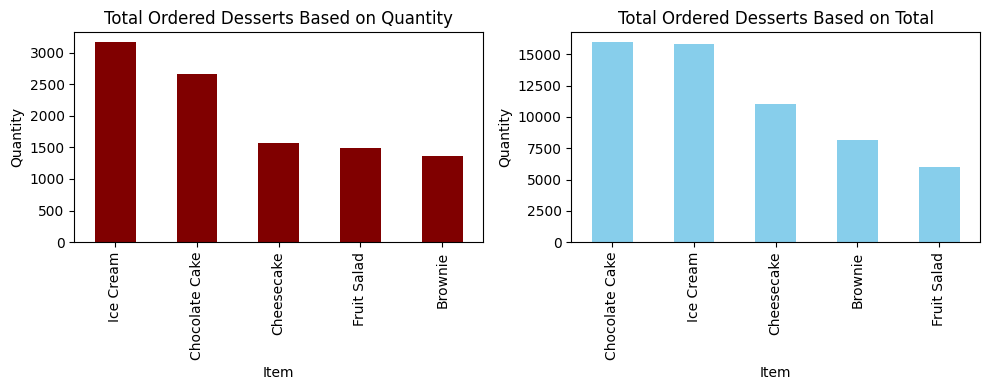

In [28]:
#Create a figure with 2 subplots
fig, (d1, d2) = plt.subplots(1, 2, figsize=(10, 4))

#1 subplot
ordered_desserts_quantity.plot(kind='bar', ax=d1, color='maroon')
d1.set_ylabel('Quantity')
d1.set_title('Total Ordered Desserts Based on Quantity')

#2 subplot
ordered_desserts_total.plot(kind='bar', ax=d2, color='skyblue')
d2.set_ylabel('Quantity')
d2.set_title('Total Ordered Desserts Based on Total')

#tight layout and display chart
plt.tight_layout()
plt.show()

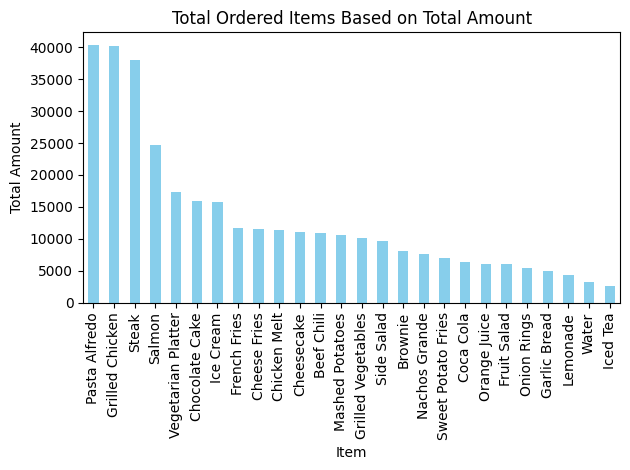

In [22]:
grouped_order_total.plot(kind='bar', color='skyblue')
plt.ylabel('Total Amount')
plt.title('Total Ordered Items Based on Total Amount')

#tight layout and display chart
plt.tight_layout()
plt.show()

# Conclusions
Explain conclusions with actionable act and ensure answering KPI